In [2]:
# new MA
import polars as pl
import numpy as np
import pandas as pd
from scipy import signal
import io
from scipy import ndimage
import matplotlib.pyplot as plt

def file_to_lazy_frame(filename):
    return pl.read_csv(filename, columns=['ts', 'z'], use_pyarrow=True).select([pl.col('ts').cast(pl.Datetime), pl.col('z').cast(pl.Int16)]).interpolate().filter(pl.col('ts').is_not_null()).filter(pl.col('z').is_not_null())

def get_filename(primary):
    return r'C:\Users\13103\Documents\data_analysis\PSG\MA\0327\IMU.csv'

xl0 = file_to_lazy_frame(get_filename(True))
xl1 = file_to_lazy_frame(get_filename(False))

# join data from each imu by the millisecond
xlz = xl0.groupby_dynamic('ts', every='1ms').agg(pl.mean('z')).rename({'z': 'z0'}).join(xl1.groupby_dynamic('ts', every='1ms').agg(pl.mean('z')).rename({'z': 'z1'}), on='ts', how='inner').select([pl.col('ts'), pl.col('z0').cast(pl.Int16), pl.col('z1').cast(pl.Int16)])

# convert into a pandas dataframe
df = xlz.to_pandas()
# convert into a pandas series
series = xlz.select(pl.col('z0')).to_series()

df = df.rename(columns={'z0': 'z'})
df['z'] = df['z']*2/9800
df['x'] = 0
df['y'] = 0
# df['ts'] = df ['ts']/10**6
# df.index = df['ts'].values.astype(np.int64)#CWT
df.index = pd.to_datetime(df['ts'].values.astype(np.int64))
csv = df['z']
csv.index = csv.index.values.astype(np.int64)


Text(0, 0.5, 'Z axis')

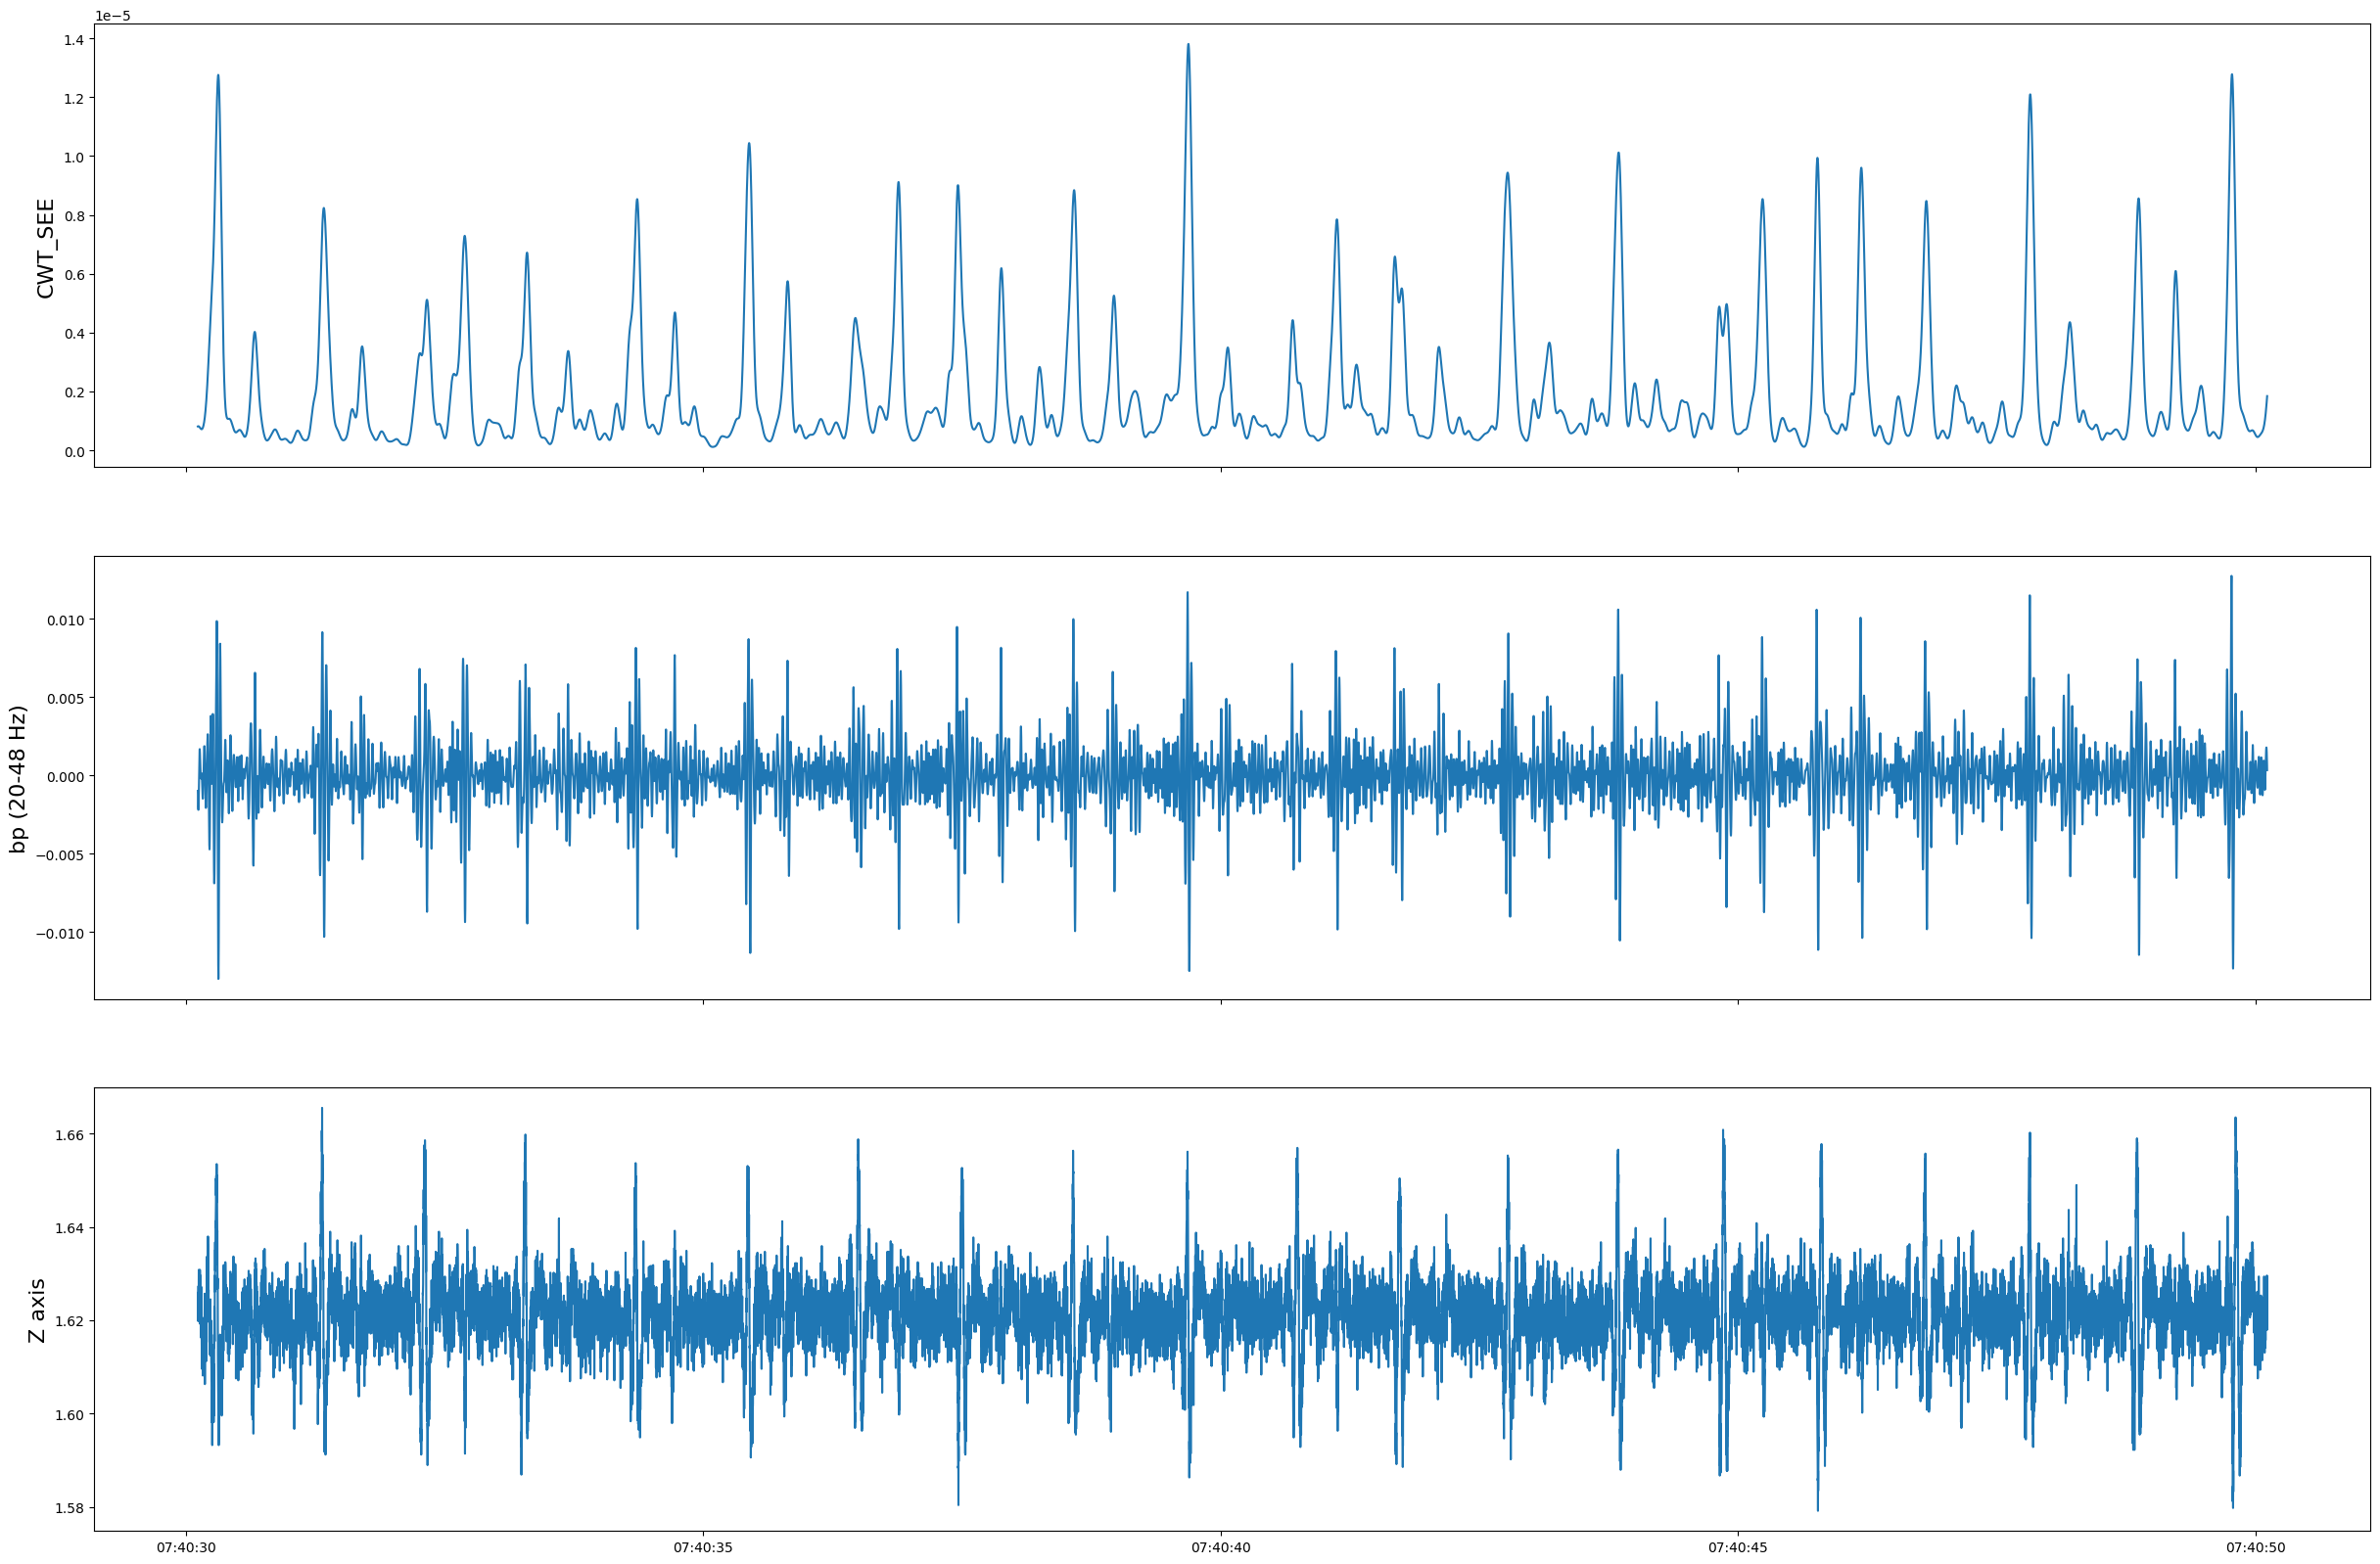

In [3]:
def shannon_energy(x):
    x_env = -x**2 * np.log(x**2)
    return(x_env)

def bandpass_filt(sig,cutoff,fs,mode):
    nyq = 0.5*fs
    wn = cutoff/nyq
    sos = signal.butter(4, wn, btype=mode,output='sos')
    return pd.DataFrame(data=signal.sosfiltfilt(sos,sig,axis=0),columns=sig.columns,index=sig.index)

##generate cwt matrix

fs = 1e-09**-1/np.median(np.diff(csv.index.values.astype(np.int64)))
csv = pd.DataFrame(csv)
test_bp = bandpass_filt(csv,(20,51),fs,'bandpass')
test_bp = test_bp.to_numpy().flatten()
cwtmtx = signal.cwt(test_bp,signal.morlet,np.arange(1,100))
tm = pd.to_datetime(csv.index)

## find cwt local maxiums 
cwt_pk = cwtmtx.T[:,1:15]
cwt_pks = cwt_pk.max(axis=1)


#use shannon energy to process oscaliating signal
cwt_se = shannon_energy(cwt_pks)
cwt_se_gs = ndimage.gaussian_filter(np.abs(cwt_se),sigma=25)#40 is taken from the average heart sound lobe of 100ms 0.1*fs/4

fig, axs = plt.subplots(3,sharex=True,figsize=(30,20))

axs[0].plot(tm[3990000:4010000],cwt_se_gs[3990000:4010000])
axs[0].set_ylabel('CWT_SEE',fontsize=16)
axs[1].plot(tm[3990000:4010000],test_bp[3990000:4010000])
axs[1].set_ylabel('bp (20-48 Hz)',fontsize=16)
axs[2].plot(tm[3990000:4010000],csv[3990000:4010000])
axs[2].set_ylabel('Z axis',fontsize=16)

In [ ]:
#interval calculation
peaks, _ = signal.find_peaks(cwt_se_gs,height=0.2*10**-5,distance=350)
itv_1 = peaks[0]
i = 0
hr = pd.DataFrame(columns=['index','Hr'])
while i < peaks.size-2:

    interval = peaks[i+2]-itv_1
    # itv_1 = peaks[i+2]
    # i = i+2
    if interval > 1200:
        interval = peaks[i+1]-itv_1
        if interval > 1200:
            interval = np.nan
        itv_1 = peaks[i+1]
        i = i+1
    else: 
        itv_1 = peaks[i+2]
        i = i+2
    

    hr_df = pd.DataFrame({'index': itv_1,'Hr':interval},index = [itv_1])
    hr = pd.concat([hr,hr_df])

hr.index = hr['index']
filtered_hr = hr[(hr['Hr']<1200) & (hr['Hr']>750)]
filtered_hr = fs/filtered_hr*60